# DUP

In [1]:
# FIND WHICH FEATURES ARE MOST IMPORTANT FOR PREDICTING user+system TIME (rank them in order)

# (1) first keep all features except ppn & dataset size - rank them

import pandas as pd

In [2]:
df = pd.read_csv("testing.csv", sep=",") #data from 22July2016 
# copy the 'dup' folder to ~/ProfilingData/.
# remove *Output* files 
# run "python extract.py dup/" to generate testing.csv

In [3]:
len(df)

32

In [4]:
df.head(n=1)

,ppn,mem,seqlen,trial,AvgRSS,AvgSharedTxt,AvgStack,AvgTotal,AvgUnsharedData,CommandTimed,...,PageSize,PercentCPU,SignalsDeliv,SocketMsgRecv,SocketMsgSent,Swaps,SystemTime,UserTime,VolCtxtSwitch,WallTime
0,11,64G,10M,1,0,0,0,0,0,./NGS-ann-program/BIN/cd-hit-dup -i ./data/no-...,...,4096,99%,0,0,0,0,3.5,42.32,1072,0:45.97


In [5]:
#find which columns are completely empty
a=len(df[df['AvgRSS'] > 0])
b=len(df[df['AvgSharedTxt'] > 0])
c=len(df[df['AvgStack'] > 0])
d=len(df[df['AvgTotal'] > 0])
e=len(df[df['AvgUnsharedData'] > 0])

print(a,b,c,d,e)

0 0 0 0 0


In [6]:
header = list(df.columns)

In [7]:
i = 1
a = 0
emptyColumns = []
for h in header:
    try:
        a=len(df[df[h] > 0])
        print(a,  h)
        if(a==0): #nothing is greater than zero for this column
            emptyColumns.append(h)
    except:
        print('......................'+ h +' not a scalar')
    i=i+1

32 ppn
......................mem not a scalar
......................seqlen not a scalar
32 trial
0 AvgRSS
0 AvgSharedTxt
0 AvgStack
0 AvgTotal
0 AvgUnsharedData
......................CommandTimed not a scalar
0 ExitStatus
32 FileSysIn
32 FileSysOut
32 InvolCtxtSwitch
32 MajorFaults
32 MaxRSS
32 MinorFaults
32 PageSize
......................PercentCPU not a scalar
0 SignalsDeliv
0 SocketMsgRecv
0 SocketMsgSent
0 Swaps
32 SystemTime
32 UserTime
32 VolCtxtSwitch
......................WallTime not a scalar


In [8]:
emptyColumns.append('trial')
#emptyColumns.append('PageSize')
emptyColumns.append('CommandTimed')
emptyColumns.append('WallTime')

In [9]:
for c in emptyColumns:
    del df[c]

In [10]:
df.head(5)

,ppn,mem,seqlen,FileSysIn,FileSysOut,InvolCtxtSwitch,MajorFaults,MaxRSS,MinorFaults,PageSize,PercentCPU,SystemTime,UserTime,VolCtxtSwitch
0,11,64G,10M,3234924,2179426,212,3,6544812,1388550,4096,99%,3.50,42.32,1072
1,11,64G,15M,4915882,3320366,608,3,9621592,2150793,4096,99%,5.43,62.54,1634
2,11,64G,20M,6599917,4467723,366,3,13416152,2892383,4096,99%,7.44,91.03,2228
3,11,64G,25M,8250892,5591773,4795,3,16387764,3612806,4096,99%,9.36,111.08,2746
4,11,64G,30M,9788169,6637009,164,3,19447720,4284645,4096,99%,11.16,130.50,3264


In [11]:
ft = df.copy(deep=True)

## [1] remove ppn and seqlen, keep all other features

In [12]:
delthis = ['ppn','seqlen']
delthis

['ppn', 'seqlen']

In [13]:
for c in delthis:
    del ft[c]

In [14]:
#DROP the lines which are NULL
#df = df[df.CommandTimed.notnull()]
len(df)

32

In [15]:
#whatisthesize = {'5M': .54, '10M': 1.2,'15M': 1.7,'20M': 2.3,'25M': 2.9,'30M': 3.4,'35M': 4.0,'40M': 4.5}

In [16]:
#ft['sizeGB'] = ft['seqlen'].map(whatisthesize)

In [17]:
#del ft['seqlen']
ft.head(2)

,mem,FileSysIn,FileSysOut,InvolCtxtSwitch,MajorFaults,MaxRSS,MinorFaults,PageSize,PercentCPU,SystemTime,UserTime,VolCtxtSwitch
0,64G,3234924,2179426,212,3,6544812,1388550,4096,99%,3.50,42.32,1072
1,64G,4915882,3320366,608,3,9621592,2150793,4096,99%,5.43,62.54,1634


In [18]:
#convert % to float
ft['Percentcpu']=ft['PercentCPU'].str.replace('[%*]', '').astype(float)/100
ft['memGB']=ft['mem'].str.replace('[G*]', '').astype(float)
ft['Y_Time']=ft['SystemTime']+ft['UserTime']
del ft['SystemTime']
del ft['UserTime']
del ft['mem']
del ft['PercentCPU']

In [19]:
ft.head(n=2)

,FileSysIn,FileSysOut,InvolCtxtSwitch,MajorFaults,MaxRSS,MinorFaults,PageSize,VolCtxtSwitch,Percentcpu,memGB,Y_Time
0,3234924,2179426,212,3,6544812,1388550,4096,1072,0.99,64.0,45.82
1,4915882,3320366,608,3,9621592,2150793,4096,1634,0.99,64.0,67.97


In [20]:
from sklearn.ensemble.forest import RandomForestRegressor
import numpy as np

In [21]:
model = RandomForestRegressor(n_estimators=100, n_jobs=-1)

In [22]:
np.random.seed()
ft['is_train']=np.random.uniform(0,1,len(ft)) <= .70
train, test = ft[ft['is_train']==True], ft[ft['is_train']==False]
del ft['is_train']
len(train)*1.0 / (len(test)+len(train))

0.78125

In [23]:
ft.columns[0:10]

Index(['FileSysIn', 'FileSysOut', 'InvolCtxtSwitch', 'MajorFaults', 'MaxRSS',
       'MinorFaults', 'PageSize', 'VolCtxtSwitch', 'Percentcpu', 'memGB'],
      dtype='object')

In [24]:
ft.columns[10]

'Y_Time'

In [25]:
features = ft.columns[0:10]
target = ft.columns[10]
X = train[features]
y = train[target].values
model.fit(X, y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=100, n_jobs=-1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [26]:
Y_prediction = model.predict(test[features])
Y_test = test[target].as_matrix()

#### Test vs Prediction

In [27]:
Y_test #Print Y values of test dataset

array([ 120.44,  141.66,   97.49,   98.42,  164.88,   67.96,  203.98])

In [28]:
Y_prediction #Print Y predicted values of test dataset

array([ 121.4958,  137.6051,  100.1612,  101.1257,  168.4166,   68.6094,
        198.8186])

## Scoring without ppn and  seqlen

In [29]:
model.score(test[features], test[target]) #which score is this ?

0.99440206808378862

In [30]:
from sklearn import cross_validation
scores = cross_validation.cross_val_score(model, ft[features], ft[target], cv=10,scoring='mean_squared_error')

In [31]:
scores

array([-10.50547415,  -9.22509668,  -1.97786691,  -6.13933826,
        -1.18049052,  -0.20660012,  -3.94607939,  -1.08361315,
       -12.00919999, -25.94834994])

In [32]:
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: -7.22 (+/- 14.85)


In [33]:
ft[target].mean(), ft[target].std() * 2

(108.51031250000001, 118.18468799728724)

In [34]:
scores = cross_validation.cross_val_score(model, ft[features], ft[target], cv=10,scoring='r2')
print("Accuracy: %0.8f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.99162022 (+/- 0.02)


## Ranking features without ppn and seqlen
#### (Feature importances with forests of trees)

In [35]:
importances = model.feature_importances_

In [36]:
std = np.std([tree.feature_importances_ for tree in model.estimators_],axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

Feature ranking:
1. feature 7 (0.216983)
2. feature 5 (0.213719)
3. feature 1 (0.191883)
4. feature 4 (0.180252)
5. feature 0 (0.154806)
6. feature 2 (0.042358)
7. feature 9 (0.000000)
8. feature 8 (0.000000)
9. feature 6 (0.000000)
10. feature 3 (0.000000)


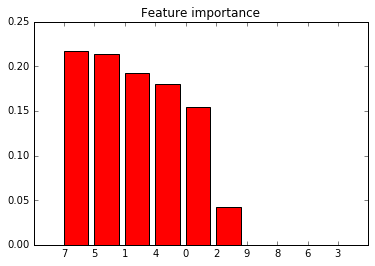

In [37]:
# Plot the feature importances of the forest
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure()
plt.title("Feature importance")
plt.bar(range(X.shape[1]), importances[indices],
       color="r")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()

In [38]:
ft.columns[0:10]

Index(['FileSysIn', 'FileSysOut', 'InvolCtxtSwitch', 'MajorFaults', 'MaxRSS',
       'MinorFaults', 'PageSize', 'VolCtxtSwitch', 'Percentcpu', 'memGB'],
      dtype='object')

In [39]:
# 0 'FileSysIn', 1'FileSysOut', 2'InvolCtxtSwitch', 3'MajorFaults', 4'MaxRSS',
# 5'MinorFaults', 6'PageSize', 7'VolCtxtSwitch', 8'Percentcpu', 9'memGB'